# Le langage [3/3]

![](fig/python-logo.png)

- Structurer un programme
- Notions de programmation objet
- Classes en Python
- Suite du micro-projet
- Usages avancés

***

*Contenu sous licence [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0), fortement inspiré de <https://fitzinger.pages.math.unistra.fr/formation-python/>*

## Structurer un programme

### Pourquoi faire ?

L'exemple du micro-projet est un script linéaire qui n'est pas réutilisable directement depuis un autre programe.

In [1]:
%pycat exos/meteo_json.py

Si on veut le réutiliser, il faut le structurer en fonctions que l'on peut appeler depuis un programme principal.

Entrer la ville :

 n'existe pas dans la base. Essayez un autre nom.
Entrer la ville :
Toulouse
Choisir le jour :
0) Mardi
1) Mercredi
2) Jeudi
3) Vendredi
4) Samedi
2


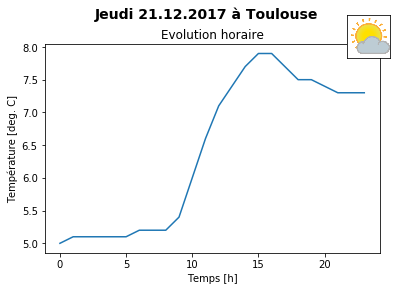

In [2]:
# %load exos/meteo_json_func.py
#!/usr/bin/env python3
"""
Process a weather forecast json file to plot the time evolution of temperature
of a given day in a given city
"""

import urllib.request
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


def get_city_from_user():
    """From user input, return a meteo json dictionary corresponding to city"""

    while True:  # Infinite loop to handle city name input
        city_name = input("Entrer la ville :\n")
        jsonfile_url = "http://www.prevision-meteo.ch/services/json/"\
                       + city_name
        f = urllib.request.urlopen(jsonfile_url)  # open url
        city_json = json.loads(f.read().decode('utf8'))
        if 'errors' in city_json:
            print("{} n'existe pas dans la base. Essayez un autre nom."
                  .format(city_name))
        else:
            return city_json


def plot_day_tempe(city_json, day_key):
    """Plot Temperature vs hour from a json dictionary for a given day_key"""

    city_name = city_json['city_info']['name']
    day = city_json[day_key]
    day_hd = day['hourly_data']  # point to hourly data

    # Get tempe = [[h1, T1], [h2, T2], ...] list
    # where h1 is the time in hour and T2 is the temperature in deg. C
    tempe = []
    for hour, data in day_hd.items():
        # get first part of time in "00H00" format and remove "H00"
        # get temperature at 2m above ground 'TMP2m'
        tempe.append([int(hour[:-3]), data['TMP2m']])
    # Alternative form using list comprehension:
    # tempe = [[int(hour[:-3]), data['TMP2m']] for hour, data in day_hd.iteritems()]

    tempe.sort()  # Sort temperatures according to the hour of day
    t = np.array(tempe).transpose()  # Transpose list of (hour, tempe)

    # Plot T = T(hour)
    fig = plt.figure()  # initialise figure
    title = "{} {} à {}".format(day['day_long'], day['date'], city_name)
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax = fig.add_subplot(111)  # initialise a plot area
    fig.subplots_adjust(top=0.85)
    ax.set_title('Evolution horaire')
    ax.set_xlabel('Temps [h]')
    ax.set_ylabel('Température [deg. C]')

    ax.plot(t[0], t[1])  # plot t[1] (tempe) as a function of t[0] (hour)

    # Add meteo icon to plot
    icon = urllib.request.urlopen(day['icon_big'])  # Open weather icon

    axicon = fig.add_axes([0.8, 0.8, 0.15, 0.15])
    img = mpimg.imread(icon)  # initialise image
    axicon.set_xticks([])  # Remove axes ticks
    axicon.set_yticks([])
    axicon.imshow(img)  # trigger the image show
    plt.show()  # trigger the figure show


def get_day(city_json):
    """From user input, return the day key in json dictonary"""

    days = {day: data['day_long'] for day, data in city_json.items()
            if day[:8] == "fcst_day"}  # Create {'fcst_day_#': week-day}
    question = "Choisir le jour :\n"
    days_list = []  # Build ['fcst_day_#', week-day] sorted list
    # This i-loop is required because "days" is not sorted:
    for i in range(5):
        key = "fcst_day_{}".format(i)
        days_list.append([key, days[key]])
        question = question + "{}) {}\n".format(i, days[key])
    while True:
        try:
            choice = int(input(question))  # Prompt user for day index
            return days_list[choice][0]  # Return 'fcst_day_#'
        except:
            print("Entrée non valide.")


if __name__ == '__main__':
    # This block is not executed if this file is imported as a module
    city_json = get_city_from_user()  # get json dict from user input
    day_key = get_day(city_json)  # get day key from user input
    plot_day_tempe(city_json, day_key)  # plot day temperature evolution


Si on définit une nouvelle fonction pour récupérer le dictionnaire de la ville :

In [3]:
import sys

def get_city(city_name):
    """return a meteo json dictionary corresponding to city_name"""

    jsonfile_url = "http://www.prevision-meteo.ch/services/json/"\
                   + city_name
    f = urllib.request.urlopen(jsonfile_url)  # open url
    city_json = json.load(f)
    if 'errors' in city_json:
        msg = "La ville n'est pas dans la base"
        sys.exit(msg)
    else:
        return city_json

On peut maintenant importer ses fonctions séparément :

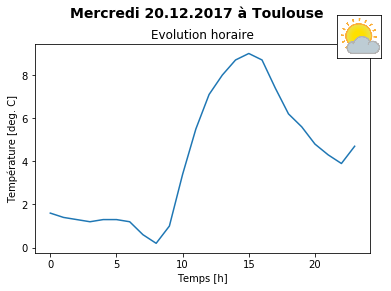

In [4]:
city_json = get_city("Toulouse")
plot_day_tempe(city_json, 'fcst_day_1')

## Notions de programmation orientée objet

La [programmation orientée objet](https://fr.wikipedia.org/wiki/Programmation_orient%C3%A9e_objet) est un paradigme de programmation qui introduit en particulier les concepts suivants :

- encapsulation
- classes
- objets
- héritage

### Encapsulation

L'encapsulation est la manière d'associer les données et les méthodes qui s'y appliquent dans un même type appelé objet.

### Classes
    
- les classes définissent ces types par leurs attributs et leurs méthodes
- les méthodes sont des fonctions qui permettent d'agir sur les attributs des objets.

### Objets

Les objets sont les instances de ces classes. Ils sont créés en *appelant* la classe comme une fonction :

    a = MaClasse(45, True, 'toto')
    b = MaClasse(78, False, 'titi')

L'objet **`a`** est une instance de la classe **`MaClasse`**.  
**`b`** est une autre instance de **`MaClasse`**.

### Héritage

- l'héritage permet de créer des classes dérivées qui partagent du code et des données de leur(s) parent(s)
- les classes filles héritent des attributs et des méthodes de leur(s) parent(s)
- Il est possible d'hériter de plusieurs classes. On parle alors d'héritage multiple.

## Classes en Python

### Définir une classe

Pour illustrer le mécanisme, on définit une classe appelée `Vecteur()` de la façon suivante :

In [5]:
class Vecteur():
    commentaire = "Cette classe est top"

    def __init__(self, x, y, z):
        self.coord = [x, y, z]

### Instancier un objet

- Pour instancier une classe, on utilise la notation d'appel de fonction
- Cet appel renvoie une instance de la classe

In [6]:
v1 = Vecteur(1., 2., 3.)
v2 = Vecteur(0., 0., 0.)

- `v1` et `v2` sont deux instances de la classe `Vecteur`
- **`self`** :
    - est le premier argument de toutes les fonctions de la classe
    - reçoit de manière automatique une référence à l'instance de l'objet
    - est nommé ainsi par convention
    - est omis lors de l'appel
    - dans la définition de la classe les attributs sont référencés par la notation `self.un_attribut`
- la méthode **`__init__()`**
    - c'est la méthode qui est appelée automatiquement lors de l'instanciation
    - elle est appelée *constructeur*
    - elle reçoit les paramètres qui permettent l'initialisation de l'objet
- Ici, `commentaire` est un attribut de la classe qui ne dépend pas de son instanciation

In [7]:
print(Vecteur.commentaire)

Cette classe est top


- `self.coord` est un attribut qui est construit lors de l'instanciation

In [8]:
print(v1.coord, v2.coord)
print('commentaire' in dir(Vecteur))  # dir() renvoie la liste des attributs de l'objet
print('commentaire' in dir(v1))
print('coord' in dir(Vecteur))
print('coord' in dir(v1))

[1.0, 2.0, 3.0] [0.0, 0.0, 0.0]
True
True
False
True


### Surcharge d'opérateur

La surcharge d'opérateur consiste à redéfinir des fonctions existantes de la classe.
Ici, afin de représenter le contenu de l'objet, on surcharge la méthode `__repr__()`.

In [9]:
class Vecteur():
    commentaire = "Cette classe est top"

    def __init__(self, x, y, z):
        self.coord = [x, y, z]

    def __repr__(self):
        """On surcharge l'opérateur __repr__ en renvoyant
        une chaîne de caractère"""
        s = ''
        for c in self.coord:
            s += '({})\n'.format(c)
        return s


La fonction `print()` appliquée à l'instance fait un appel à `__repr__()`.

In [10]:
v1 = Vecteur(1., 2., 3.)
print(v1)


(1.0)
(2.0)
(3.0)



Un autre exemple de surcharge d'une fonction intrinsèque : `__add__()`


In [11]:
def __add__(self, v):
    return Vecteur(self.coord[0] + v.coord[0],
                   self.coord[1] + v.coord[1],
                   self.coord[2] + v.coord[2])

Vecteur.__add__ = __add__

v1 = Vecteur(1., 2., 3.)
v2 = Vecteur(3., 2., 1.)
print(v1 + v2)

(4.0)
(4.0)
(4.0)



**Exercice :** Implémenter la méthode `scal()` qui renvoie le produit scalaire de deux vecteurs $(\vec{v}\cdot \vec{w} = v_{x}w_{x}+v_{y}w_{y}+v_{z}w_{z})$.

In [12]:
def scal(self, v):
    # --- votre code ici ---
    pass

Vecteur.scal = scal

v1 = Vecteur(2., 3., 4.)
v2 = Vecteur(6., 4., 3.)
print(v1.scal(v2))

None


<button data-toggle="collapse" data-target="#vecteur" class='btn btn-primary'>Solution</button>
<div id="vecteur" class="collapse">
    
```python
class Vecteur():
    commentaire = "Cette classe est top"

    def __init__(self, x, y, z):
        self.coord = [x, y, z]

    def __repr__(self):
        """On surcharge l'opérateur __repr__ pour renvoyer
        une chaîne de caractère"""
        s = ''
        for c in self.coord:
            s += '({})\n'.format(c)
        return s

    def __add__(self, v):
        return Vecteur(self.coord[0] + v.coord[0],
                       self.coord[1] + v.coord[1],
                       self.coord[2] + v.coord[2])

    def scal(self, v):
        return (self.coord[0]*v.coord[0] +
                self.coord[1]*v.coord[1] +
                self.coord[2]*v.coord[2])

if __name__ == '__main__':

    v1 = Vecteur(2., 3., 4.)
    v2 = Vecteur(6., 4., 3.)
    print(v1)
    print(v2)
    print(v1 + v2)
    print(v1.scal(v2))
```

### Héritage

Pour spécifier les classes dont on hérite, il suffit de les lister en paramètres de la définition de classe :

    class Fille(Parent1, Parent2):
        pass

> **Note :** Nous n'aborderons pas les classes ayant plusieurs ancêtres dans le cadre de ce cours. Vous trouverez la documentation sur ce sujet [ici](https://docs.python.org/3/tutorial/classes.html#inheritance).

En guise d'exemple, prenons la classe ci-dessous.

In [13]:
class Humain():

    def __init__(self, nom, age):
        self.nom = nom
        self.age = age

    def vieux(self):
        return self.age >= 50

Créons maintenant des instances de cette classe.

In [14]:
a = Humain('Alain', 42)
b = Humain('Bertrand', 53)
c = Humain('Corine', 37)

fratrie = [a, b ,c]

for h in fratrie:
    print('{} est {}'.format(h.nom, 'vieux' if h.vieux() else 'jeune' ))

Alain est jeune
Bertrand est vieux
Corine est jeune


Illustrons maintenant le mécanisme d'héritage.

In [15]:
class Personne(Humain):
    
    def __init__(self, nom, age, sexe):
        super(Personne, self).__init__(nom, age)
        self.sexe = sexe
    
    def porte_les_bebes(self):
        return self.sexe.lower() in ('f', 'femme', 'fille')

    
a = Personne('Alain', 42, 'h')
b = Personne('Bertrand', 53, 'h')
c = Personne('Corinne', 37, 'f')

pfratrie = [a, b ,c]

- Ici, nous faisons hériter la classe **`Humain`** à la classe **`Personne`**
- La classe **`Personne`** hérite des méthodes de la **`Humain`**

In [16]:
for p in pfratrie:
    print('{} est {}'.format(p.nom, 'vieux' if p.vieux() else 'jeune' ))

Alain est jeune
Bertrand est vieux
Corinne est jeune


- En redéfinissant la fonction **`__init__()`**, nous *surchargeons* la classe **`Humain`**.
- La fonction **`super()`** permet d'appeler le constructeur de la classe mère.
- En définissant la fonction **`porte_les_bebes()`**, nous *étendons* la classe **`Humain`**.

In [17]:
for p in pfratrie:
    if p.porte_les_bebes():
        print('{} peut porter des bébés'.format(p.nom))

Corinne peut porter des bébés


## Suite du micro-projet

### Objectif pédagogique

- Manipuler les fonctions
- Manipuler les classes
    - Définition
    - Instanciation
    - Accès aux attributs
    - Appel des méthodes
- Structurer un projet
- Gestion des arguments en ligne de commande
- Mettre en place des tests unitaires

### Exercice sur les classes

On veut superposer les courbes *heure-température* de plusieurs villes sur le même graphe. Pour ce faire, il faut :

1. Définir une classe **`City`** qui dispose d'une méthode qui retourne les tableaux 1D *hour* et *temperature* pour un jour donné.
2. Instancier cette classe pour construire autant d'objets **City** que nécessaire
3. Appeler une fonction qui admet comme arguments les objets **City** ainsi que le numéro du jour

Pour vous simplifier le travail, nous avons écrit l'ébauche d'un script python dans [exos/meteo_city.py](exos/meteo_city.py). En l'état, ce script s'exécute mais ne fait rien. Editez-le dans Spyder et écrivez le code nécessaire pour le rendre fonctionnel là où les commentaires vous y invitent.

Lorsque votre implantation sera terminée, la cellule ci-dessous devra s'exécuter correctement.

> **Note :** Pour importer le module `meteo_city` depuis le package `exos`, il faut que le répertoire `exos` contiennent un fichier `__init__.py`

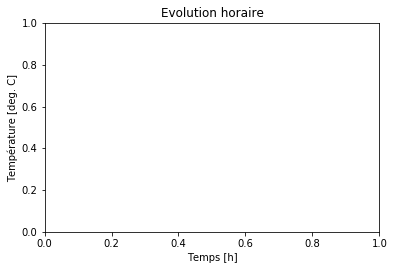

In [18]:
from exos import meteo_city as meteo
toulouse = meteo.City('Toulouse')
paris = meteo.City('Paris')
meteo.plot_day_temperature(toulouse, paris, day_number=3)

In [19]:
help(meteo)

Help on module exos.meteo_city in exos:

NAME
    exos.meteo_city - Process weather forecast json files to plot the time evolution of temperature

CLASSES
    builtins.object
        City
    
    class City(builtins.object)
     |  Loads a json dictionary downloaded from city name
     |  and provide a method to search for day temperature
     |  
     |  Methods defined here:
     |  
     |  __init__(self, city_name)
     |      Loads city json dict
     |  
     |  get_temperature(self, day_key)
     |      store hour and temperature in numpy arrays for given day_key
     |  
     |  ----------------------------------------------------------------------
     |  Data descriptors defined here:
     |  
     |  __dict__
     |      dictionary for instance variables (if defined)
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)

FUNCTIONS
    plot_day_temperature(*cities, day_number=0)
        Plot temperature vs hour for an arbitrary number of

### Exercice avec `argparse`

Dans un nouveau fichier python :
- importer le fichier `exos/correction/meteo_city.py` comme un module
- ajoutez la gestion des arguments en ligne de commande avec `argparse` (cf. [Gestion des arguments](../J2/03-InitPython-microprojet.ipynb#Gestion-des-arguments))

<button data-toggle="collapse" data-target="#meteo_argparse" class='btn btn-primary'>Solution</button>
<div id="meteo_argparse" class="collapse">
    
```python
"""
Process weather forecast json files to plot the time evolution of temperature
"""

from correction import meteo_city as mc
import argparse

URL_PREFIX = "http://www.prevision-meteo.ch/services/json/"


def do_argparse():
    """Handle command-line arguments"""

    parser = argparse.ArgumentParser(description='Process some integers.')
    parser.add_argument('-d', '--day', metavar='INTEGER', default=0, type=int,
                        help='day for the weather forecast (0 to 4)')
    parser.add_argument('city', metavar='STRING', nargs='*',
                        help='city for which to get the weather forecast')
    return parser.parse_args()

if __name__ == '__main__':
    # This block is not executed if this file is imported as a module
    args = do_argparse()

    if args.city:
        cities = [mc.City(city_name) for city_name in args.city]
    else:
        city_name = input("Enter city:\n")
        cities = (mc.City(city_name),)

    mc.plot_day_temperature(*cities, day_number=args.day)
```

### Exercice sur l'héritage

Toujours dans l'objectif de superposer des courbes de températures, on veut pouvoir charger également des données définies par leurs coordonnées géographiques.

En effet, le site www.prevision-meteo.ch supporte les requêtes sous la forme   
http://www.prevision-meteo.ch/services/json/lat=45.32lng=10  
où `lat=45.32lng=10` désigne la latitude et la longitude.  

Pour ce faire, à partir de la classe **`City`**, on va dériver la classe **`Location`** qui sera instanciée de la façon suivante :
```
trou_perdu = Location(lat=45.32, lng=10)
```

À partir du fichier [exos/correction/meteo_city.py](exos/correction/meteo_city.py), écrivez la classe dérivée **`Location`**.  
Lorsque votre implantation sera terminée, la cellule ci-dessous devra s'exécuter correctement.

In [21]:
from exos import meteo_city
toulouse = meteo.City('Toulouse')
paris = meteo.City('Paris')
# --- Décommentez ci-dessous ---
# trou_perdu = meteo.Location(lat=45.32, lng=10)
# meteo.plot_day_temperature(toulouse, paris, trou_perdu, day_number=3)

In [22]:
help(meteo.City)

Help on class City in module exos.meteo_city:

class City(builtins.object)
 |  Loads a json dictionary downloaded from city name
 |  and provide a method to search for day temperature
 |  
 |  Methods defined here:
 |  
 |  __init__(self, city_name)
 |      Loads city json dict
 |  
 |  get_temperature(self, day_key)
 |      store hour and temperature in numpy arrays for given day_key
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



#### Exercice bonus

Continuez a augmenter l'ergonomie de votre script en ajoutant/modifiant une ou plusieurs options en ligne de commande pour gérer les localisations, les villes, etc...

## Usages avancés

- expressions lambda
- tests unitaires
- installer des paquets
- environnements virtuels
- chaînes de documentation

### Les expressions lambda

Elles permettent de définir très concisement des fonctions anonymes (sans nom, comme avec ``def``).

    # Création d'une fonction et assignation a une variable
    func = lambda [arg1]...: expr
    # Appel de fonction par la variable
    func(...)

ce qui est équivalent à:

    def _noname([arg1]...):
        return expr
    
    func = _noname
    del _noname
    
    func(...)

En plus court...


Plus d'informations sur les expressions [``lambda``](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions).

Elles sont utilisées par exemple, pour passer des petits bouts de code en paramètre à d'autres fonctions :

In [ ]:
L1 = list('AlpHabetIZation')
L2 = list(L1)
print(L1)
L1.sort(key=lambda x: x.lower())
print('A'.lower())
L2.sort()
print(L1)
print(L2)

### Les tests unitaires

Python permet d'écrire assez facilement des tests unitaires, grâce au module [``unittest``](https://docs.python.org/3/library/unittest.html) de sa librairie standard. Ce module ressemble assez aux tests unitaires java [JUnit](http://junit.org).

- [exos/vieux.py](exos/vieux.py) :
    - C'est un exemple d'utilisation, sous la forme d'un module importable
    - Il définit une fonction **``vieux(age)``** qui retourne une valeur booléenne indiquant si l'age donné est au-dessus d'un seuil (une constante du module)
    - Cette fonction lève des exceptions si le paramètre donné n'est pas valide
- [exos/tunitaires.py](exos/tunitaires.py) est un module contenant le code qui permet de tester la fonction **``vieux.vieux()``**

In [23]:
%run exos/tunitaires.py -v

test_vieux (__main__.WidgetTestCase) ... ok
test_vieux_raise_type (__main__.WidgetTestCase) ... ok
test_vieux_raise_value (__main__.WidgetTestCase) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.007s

OK


- Il existe une autre philosophie de tests intégrés à la documentation interne : le module [``doctest``](https://docs.python.org/3/library/doctest.html).
- Il est possible de combiner ces solutions de testing/documentation.

En pratique dans des projets plus importants, les tests sont agencés en une suite de tests.
L'exécution des suites de tests est effectuée grâce a des pilotes comme [pytest](http://pytest.org) ou [nose](http://nose.readthedocs.io/en/latest/index.html). Ces pilotes permettent, entre autres, le lancement de multiples tests en parallèle ainsi que des rapports de couverture de code.

#### Exercice

- Ajoutez un module de tests unitaires pour le projet météo.

### Installer des paquets

Pour installer des modules additionnels disponibles par exemple sur le [Python Package Index](https://pypi.python.org/pypi), vous pouvez utiliser le gestionnaire de paquet [``pip``](https://pip.pypa.io)

    pip install valerius

Cette commande fera une installation système (il vous faut donc être administrateur de la machine) mais vous pouvez faire une installation dans votre compte avec l'option ``--user``. Il faudra alors ajouter le chemin ``~/.local/lib/python3.5/site-packages`` à la variable d'environnement ``PYTHONPATH`` pour que python trouve les paquets isntallés au moment d'un ``import``.

Pour fabriquer des paquets installables de cette manière, visitez [cette page](https://packaging.python.org/).

### Environnements virtuels

Pour pouvoir profiter de plusieurs environnements python qui ont des modules différents installés, il y a le mécanisme  [venv](https://docs.python.org/3/library/venv.html).

```
$ mkdir test_py35
$ virtualenv -p python3.5 test_py35
$ test_py35/bin/activate
(test_py35) $
```

Vous êtes alors dans un environnement où vous pouvez installer des paquets indépendemment du système :

    (test_py35) $ pip install valerius

## Les chaînes de documentation

- Dans chaque entité de type module, classe, fonction, etc., on peut insérer une ligne de code sous la forme d'une chaîne de caractères qui sera considérée comme la documentation de cette entité
- Cette documentation sera accessible grâce a la fonction interne ``help()``.
- Il est possible d'utiliser ces ``docstring`` pour d'autres usages, comme la génération automatique de pages de  documentation HTML ou de contenir le code de tests unitaires (c.f. [``doctest``](https://docs.python.org/3/library/doctest.html)).

In [24]:
class LaClasse():
    '''La classe, c'est la classe'''
    pass

def func():
    '''La fonction func() nous met le funk !'''
    pass

help(LaClasse)
help(func)

Help on class LaClasse in module __main__:

class LaClasse(builtins.object)
 |  La classe, c'est la classe
 |  
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

Help on function func in module __main__:

func()
    La fonction func() nous met le funk !

